In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
#import pandas_profiling
import os
import zipfile
import sys
import boto
from boto.s3.key import Key
import boto.s3.connection
from os.path import basename
from sklearn.preprocessing import LabelEncoder
color = sns.color_palette()
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing, cross_validation, neighbors

/Users/sonalichaudhari/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Reading the CSV files
details_2017 = pd.read_csv('/Users/sonalichaudhari/Desktop/ADS_MidTerm/Data/properties_2017.csv',low_memory=False)
trans_2017 = pd.read_csv('/Users/sonalichaudhari/Desktop/ADS_MidTerm/Data/train_2017.csv',low_memory=False)

In [5]:
def messingDataCount(yeardf):
    missing_data = yeardf.isnull().sum().to_frame(name='Missing_Count').reset_index()
    missing_data['Missing_percent'] = (missing_data['Missing_Count']/yeardf.shape[0])*100
    missing_data.head()
    missing_data = missing_data.sort_values(by='Missing_percent', axis=0, ascending=True)
    features = missing_data['index'][(missing_data.Missing_percent <30)]
    return features

In [6]:
features = messingDataCount(details_2017)
# Including on the features in the merge data
details_2017_gf = details_2017[features]

In [7]:
# Separating the year and month from the transactiondate column
def transactionColumnSeperation(transactiondf):
    transactiondf['transactiondate'] = pd.to_datetime(transactiondf['transactiondate'])
    transactiondf['year'] = transactiondf['transactiondate'].dt.year
    transactiondf['month'] = transactiondf['transactiondate'].dt.month

In [8]:
transactionColumnSeperation(trans_2017)

In [36]:
merge_2017 = pd.merge(trans_2017,details_2017_gf,on='parcelid')

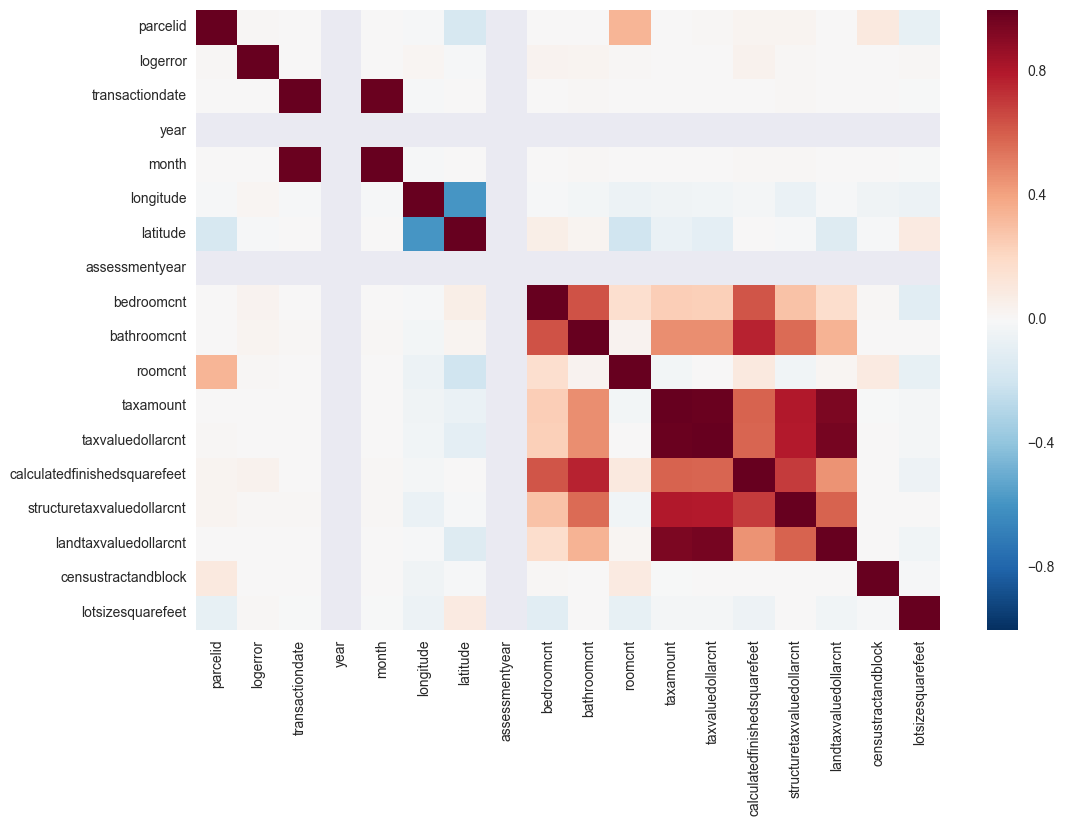

In [69]:
#Identify numerical columns to produce a heatmap
catcols = ['airconditioningtypeid','architecturalstyletypeid','buildingqualitytypeid','buildingclasstypeid','decktypeid','fips','hashottuborspa','heatingorsystemtypeid','pooltypeid10','pooltypeid2','pooltypeid7','propertycountylandusecode','propertylandusetypeid','propertyzoningdesc','rawcensustractandblock','regionidcity','regionidcounty','regionidneighborhood','regionidzip','storytypeid','typeconstructiontypeid','yearbuilt','taxdelinquencyflag']
numcols = [x for x in merge_2017.columns if x not in catcols]

#Lets start by plotting a heatmap to determine if any variables are correlated
plt.figure(figsize = (12,8))
sns.heatmap(data=merge_2017[numcols].corr())
plt.show()
plt.gcf().clear()

# Dealing with redundant columns

In [38]:
def deleteRedundantColumns(specificYear):
    # Missing rows in the columns
    specificYear[['bathroomcnt','fullbathcnt','calculatedbathnbr']].isnull().sum().sort_values()
    del specificYear['fullbathcnt']
    del specificYear['calculatedbathnbr']

In [39]:
deleteRedundantColumns(merge_2017)

# 'calculatedfinishedsquarefeet' and 'finishedsquarefeet12' are the same meaning columns

In [40]:
# Missing rows in the columns
def finishedSquarefeet(spYear):
    spYear[['calculatedfinishedsquarefeet','finishedsquarefeet12']].isnull().sum().sort_values()
    #Dropping column 'finishedsquarefeet12'
    del spYear['finishedsquarefeet12']


In [41]:
finishedSquarefeet(merge_2017)

# Removing nan Latitude and longitude (minimal nan values)

In [42]:
merge_2017 = merge_2017.dropna(subset=['latitude'])

In [43]:
merge_2017.isnull().sum()

parcelid                           0
logerror                           0
transactiondate                    0
year                               0
month                              0
fips                               0
propertylandusetypeid              0
rawcensustractandblock             0
regionidcounty                     0
longitude                          0
latitude                           0
assessmentyear                     0
bedroomcnt                         0
bathroomcnt                        0
roomcnt                            0
propertycountylandusecode          0
regionidzip                       50
taxamount                          5
taxvaluedollarcnt                  1
calculatedfinishedsquarefeet     201
structuretaxvaluedollarcnt       115
yearbuilt                        270
landtaxvaluedollarcnt              2
regionidcity                    1472
censustractandblock              247
lotsizesquarefeet               8258
dtype: int64

# filling the missing data in 'heatingorsystemtypeid' column

In [44]:
# def heavingSystemMissingData(specYear):
#     heat = specYear[['parcelid','yearbuilt','heatingorsystemtypeid']]
#     # The system used the most 
#     Mode = specYear['heatingorsystemtypeid'].mode()[0]

#     year = list(specYear['yearbuilt'].unique())
#     heat_system= {}
#     for y in year:
#         temp = heat[heat.yearbuilt== y]
#         #sys = temp["heatingorsystemtypeid"][(temp['count']==m)].values[0]
#         #heat_system[y]= sys
#         #temp['heatingorsystemtypeid']=temp['heatingorsystemtypeid'].replace(['nan'], m
#         if(temp.shape == temp[temp.isnull().any(axis=1)].shape ):
#             temp['heatingorsystemtypeid'].fillna(Mode, inplace=True)
#         else:
#             m = temp['heatingorsystemtypeid'].mode()[0]
#             temp['heatingorsystemtypeid'].fillna(m, inplace=True)
#         heat.loc[heat.parcelid.isin(temp.parcelid), ['heatingorsystemtypeid']] = temp[['heatingorsystemtypeid']]
#     heat['heatingorsystemtypeid'].fillna(heat['heatingorsystemtypeid'].mode()[0], inplace = True)      
#     specYear.loc[specYear.parcelid.isin(heat.parcelid), ['heatingorsystemtypeid']] = heat[['heatingorsystemtypeid']]

In [45]:
#heavingSystemMissingData(merge_2016)
#heavingSystemMissingData(merge_2017)

# Catagorical Data

## Mising Data

In [46]:
def propertyCountylandCodeFillNAN (sampleDf):
    #This is for the propertycountylandusecode column and it replaces all the nan with the mode of the column
    sampleDf['propertycountylandusecode'] = sampleDf['propertycountylandusecode'].apply(lambda x: np.nan if x == 0 else x) #and type(x) is not object else x)    # for a column in train_df, change any zero values to Nan
    sampleDf['propertycountylandusecode'] = sampleDf['propertycountylandusecode'].fillna(sampleDf['propertycountylandusecode'].mode()[0]) #fill Nan values with mode values

In [47]:
propertyCountylandCodeFillNAN (merge_2017)

In [48]:
def propertyzoningdescNanValues(dataFrame):
    #Creating another dataframe from the main 2017 merged dataframe to just have these three columns
    propertyLandUseCodedf = dataFrame[['parcelid','propertycountylandusecode', 'propertyzoningdesc']]
    #Finding the mode of the propertyzoningdesc column
    propMode = propertyLandUseCodedf['propertyzoningdesc'].mode()[0]

    #Looping through each unique code od the propertycountylandusecode
    for code in list(propertyLandUseCodedf['propertycountylandusecode'].unique()):
        #For each code that comes in I am creating another dataframe that contains al the rows with just these propertyCounty codes
        tempdf = propertyLandUseCodedf.loc[propertyLandUseCodedf['propertycountylandusecode'] == code]
        #First validating that if all the rows in this tempdf has null then I will replace the nan with the overall mode from propMode
        if(tempdf.shape == tempdf[tempdf.isnull().any(axis=1)].shape ):
            tempdf['propertyzoningdesc'].fillna(propMode, inplace=True)
        #If this is not the case then I am finding the mode of the tempdf during each loop and replacing na with the mode
        else:
            themode = tempdf['propertyzoningdesc'].mode()[0]
            tempdf['propertyzoningdesc'].fillna(themode, inplace=True)
        #After each loop I am replacing all the values in the propertyLandUseCodedf with the vales from tempdf based on the parcelid
        propertyLandUseCodedf.loc[propertyLandUseCodedf.parcelid.isin(tempdf.parcelid), ['propertyzoningdesc']] = tempdf[['propertyzoningdesc']]
    #here I am replacing the whole column in main df with the propertyLandUseCodedf based on parcelid
    dataFrame.loc[dataFrame.parcelid.isin(propertyLandUseCodedf.parcelid), ['propertyzoningdesc']] = propertyLandUseCodedf[['propertyzoningdesc']]

In [49]:
# propertyzoningdescNanValues(merge_2016)
# propertyzoningdescNanValues(merge_2017)

## Dummy Variables Replacement

In [2]:
def replaceStrWithDummyVar (maindf):
    lb_make = LabelEncoder()
    maindf["propertycountylandusecode"] = lb_make.fit_transform(maindf["propertycountylandusecode"])
    maindf[["propertycountylandusecode"]]
    lb_makeDesc = LabelEncoder()
    #maindf["propertyzoningdesc"] = lb_makeDesc.fit_transform(maindf["propertyzoningdesc"])
    #maindf[["propertyzoningdesc"]]
    lb_makeDesc = LabelEncoder()
    maindf["transactiondate"] = lb_makeDesc.fit_transform(maindf["transactiondate"])
    maindf[["transactiondate"]]

In [3]:
replaceStrWithDummyVar(merge_2017)

NameError: name 'merge_2017' is not defined

# KNN 

## 'yearbuilt'

In [52]:
# 'yearbuilt' column

#def yearbuilt(y):
whole = ['latitude','longitude','yearbuilt','parcelid']
base = ['latitude','longitude']#,'parcelid'
target_column = 'yearbuilt'

null = merge_2017[target_column].isnull()
not_null = ~null
num_miss = null.sum()
num_miss

X_train = merge_2017.loc[not_null, whole].sample(frac = 1)

X_train.latitude.astype(int)
X_train.longitude.astype(int)
X_train.yearbuilt.astype(int)
X=X_train[base].values

y = X_train[target_column].astype(int)
y = y.values

Y_target =merge_2017.loc[null, whole].sample(frac = 1)
Y_target.latitude.astype(int)
Y_target.longitude.astype(int)

Y =Y_target[['latitude','longitude']].values

clf = neighbors.KNeighborsClassifier()
clf.fit(X,y)
accuracy = clf.score(X, y) #test
print(accuracy) #this works fine

#Y = Y.reshape(len(X), -1)
prediction = clf.predict(Y)

0.574447994412


In [53]:
Y_target.loc[Y_target.yearbuilt.isnull(),'yearbuilt'] = prediction
merge_2017.loc[merge_2017.parcelid.isin(Y_target.parcelid), ['yearbuilt']] = Y_target[['yearbuilt']]

In [65]:
merge_2017[['calculatedfinishedsquarefeet']].isnull().sum()

calculatedfinishedsquarefeet    201
dtype: int64

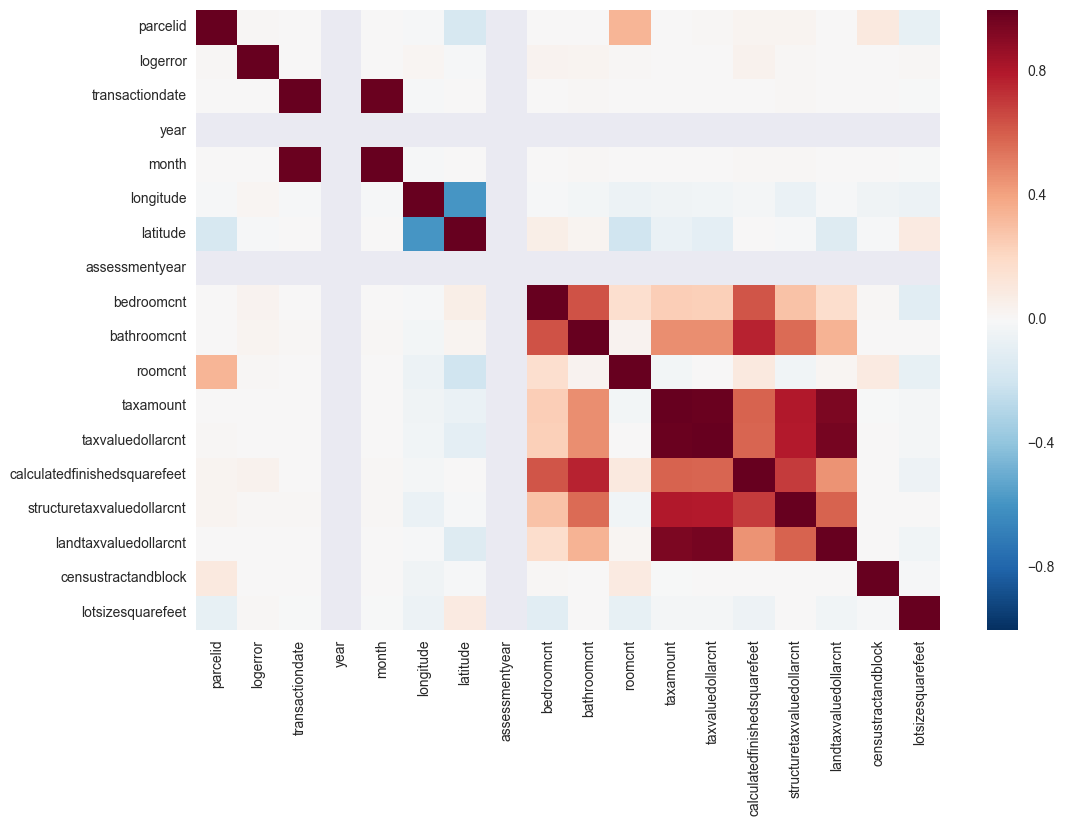

In [70]:
#Identify numerical columns to produce a heatmap
catcols = ['airconditioningtypeid','architecturalstyletypeid','buildingqualitytypeid','buildingclasstypeid','decktypeid','fips','hashottuborspa','heatingorsystemtypeid','pooltypeid10','pooltypeid2','pooltypeid7','propertycountylandusecode','propertylandusetypeid','propertyzoningdesc','rawcensustractandblock','regionidcity','regionidcounty','regionidneighborhood','regionidzip','storytypeid','typeconstructiontypeid','yearbuilt','taxdelinquencyflag']
numcols = [x for x in merge_2017.columns if x not in catcols]

#Lets start by plotting a heatmap to determine if any variables are correlated
plt.figure(figsize = (12,8))
sns.heatmap(data=merge_2017[numcols].corr())
plt.show()
plt.gcf().clear()

## KNN calculatedfinishedsquarefeet

In [88]:
base = 'structuretaxvaluedollarcnt','bathroomcnt','calculatedfinishedsquarefeet','parcelid'
target_column = 'calculatedfinishedsquarefeet'

null = merge_2017[target_column].isnull()
not_null = ~null
num_miss = null.sum()
num_miss

X_train = merge_2017.loc[not_null, base].sample(frac = 1)

X_train.structuretaxvaluedollarcnt.astype(int)
X_train.bathroomcnt.astype(int)
X_train.calculatedfinishedsquarefeet.astype(int)
X=X_train[['structuretaxvaluedollarcnt','bathroomcnt',]].values

y = X_train[target_column].astype(int)
y = y.values

Y_target =merge_2017.loc[null, base].sample(frac = 1)
Y_target.structuretaxvaluedollarcnt.astype(int)
Y_target.bathroomcnt.astype(int)

Y =Y_target[['structuretaxvaluedollarcnt','bathroomcnt',]].values

clf = neighbors.KNeighborsClassifier()
clf.fit(X,y)
accuracy = clf.score(X, y) #test
print(accuracy) #this works fine

#Y = Y.reshape(len(X), -1)
prediction = clf.predict(Y)

0.194603117165


In [89]:
Y_target.loc[Y_target.calculatedfinishedsquarefeet.isnull(),'calculatedfinishedsquarefeet'] = prediction
merge_2017.loc[merge_2017.parcelid.isin(Y_target.parcelid), ['calculatedfinishedsquarefeet']] = Y_target[['calculatedfinishedsquarefeet']]

# Additional columns

In [135]:
def ageColumn(yeardataf):
    yeardataf['age'] =2017-yeardataf['yearbuilt']

In [136]:
ageColumn(merge_2017)

# Concatinating the 2016 and 2017 dataframes

# Reading file into CSV

In [287]:
directory = os.path.dirname(os.getcwd()) 
cur_path = directory+'\\Assignment2'
cur_path
df_concat.to_csv('zillowData.csv', sep=',')

# Uploading csv to AWS

In [37]:
AWS_ACCESS_KEY_ID=''
AWS_SECRET_ACCESS_KEY=''
try:
    connect = boto.connect_s3(AWS_ACCESS_KEY_ID,AWS_SECRET_ACCESS_KEY)

except:
    print("incorrect aws access key and/or secret key")

In [38]:
#connection = boto.connect_s3(AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY)

#csvFile = 'zillowData.csv'
zipname = "zillowdata.zip"
z = zipfile.ZipFile(zipname, "w")
z.write('zillowData.csv')
cur_path
bucket_name = 'zillowdatampsc'



loc = boto.s3.connection.Location.USWest

bucket = connect.create_bucket(bucket_name, location=loc)
def percent_cb(complete, total):
    sys.stdout.write('.')
    sys.stdout.flush()

s3key = boto.s3.key.Key(bucket)
s3key.key = zipname
s3key.set_contents_from_filename(zipname, cb=percent_cb, num_cb=10)

.......

ConnectionAbortedError: [WinError 10053] An established connection was aborted by the software in your host machine

In [72]:
merge_2017.isnull().sum().sort_values()

parcelid                           0
yearbuilt                          0
propertycountylandusecode          0
roomcnt                            0
bathroomcnt                        0
assessmentyear                     0
latitude                           0
longitude                          0
bedroomcnt                         0
rawcensustractandblock             0
propertylandusetypeid              0
fips                               0
month                              0
year                               0
transactiondate                    0
logerror                           0
regionidcounty                     0
taxvaluedollarcnt                  1
landtaxvaluedollarcnt              2
taxamount                          5
regionidzip                       50
structuretaxvaluedollarcnt       115
calculatedfinishedsquarefeet     201
censustractandblock              247
regionidcity                    1472
lotsizesquarefeet               8258
dtype: int64

## 'taxvaluedollarcnt' 'taxamount' and 'landtaxvaluedollarcnt' 

In [75]:
merge_2017[['taxvaluedollarcnt','landtaxvaluedollarcnt','taxamount']].isnull().sum()

taxvaluedollarcnt        1
landtaxvaluedollarcnt    2
taxamount                5
dtype: int64

In [76]:
merge_2017[['taxvaluedollarcnt','landtaxvaluedollarcnt','assessmentyear']][merge_2017.taxvaluedollarcnt.isnull() | merge_2017.landtaxvaluedollarcnt.isnull()]

,taxvaluedollarcnt,landtaxvaluedollarcnt,assessmentyear
21149,14811.0,NaN,2016.0
62558,NaN,NaN,2016.0


In [78]:
merge_2017['taxvaluedollarcnt'].fillna((merge_2017['taxvaluedollarcnt'].mean()), inplace=True)
merge_2017['landtaxvaluedollarcnt'].fillna((merge_2017['landtaxvaluedollarcnt'].mean()), inplace=True)
merge_2017['taxamount'].fillna((merge_2017['taxamount'].mean()), inplace=True)

In [80]:
merge_2017.isnull().sum().sort_values()

parcelid                           0
landtaxvaluedollarcnt              0
yearbuilt                          0
taxvaluedollarcnt                  0
taxamount                          0
propertycountylandusecode          0
roomcnt                            0
bathroomcnt                        0
assessmentyear                     0
latitude                           0
bedroomcnt                         0
regionidcounty                     0
rawcensustractandblock             0
propertylandusetypeid              0
fips                               0
month                              0
year                               0
transactiondate                    0
logerror                           0
longitude                          0
regionidzip                       50
structuretaxvaluedollarcnt       115
calculatedfinishedsquarefeet     201
censustractandblock              247
regionidcity                    1472
lotsizesquarefeet               8258
dtype: int64

In [139]:
# x, y = pd.Series(merge_2016.taxvaluedollarcnt, name="x_var"), pd.Series(merge_2016.landtaxvaluedollarcnt, name="y_var")
# ax = sns.regplot(x=x, y=y, marker="+")
# plt.show()

In [89]:
# fig,ax1= plt.subplots()
# fig.set_size_inches(20,10)
# merge_2016["regionidcounty"] = merge_2016["regionidcounty"].map(lambda x:str(x).split(".")[0])
# yearMerged = merge_2016.groupby(['regionidcounty', 'regionidzip'])["parcelid"].count().unstack('regionidzip').fillna(0)
# yearMerged.plot(kind='bar', stacked=False,ax=ax1)

# ax1.set_xlabel('Different County in California',fontsize=20, color='red')
# ax1.set_ylabel('Count of house',fontsize=14, color='red')
# plt.show()

In [223]:
#merge_2016[['regionidcounty','parcelid', 'regionidcity']][merge_2016.regionidzip.isnull()].sort_values(by='regionidcounty')

In [113]:
merge_2016[['regionidcounty','parcelid', 'regionidcity','regionidzip']][merge_2016.regionidzip.isnull()].groupby(merge_2016.regionidcounty).count()

,regionidcounty,parcelid,regionidcity,regionidzip
regionidcounty,,,,


### 'regionidcity'

In [95]:
def missingcity(m):
    city = m[['regionidcounty','parcelid', 'regionidcity']]
    Mode = m['regionidcity'].mode()[0]
    county= list(city['regionidcounty'].unique())

    for c in county:
        temp = city[city.regionidcounty == c]
        if(temp.shape == temp[temp.isnull().any(axis=1)].shape ):
                temp['regionidcity'].fillna(Mode, inplace=True)
        else:
                c = temp['regionidcity'].mode()[0]
                temp['regionidcity'].fillna(c, inplace=True)
        city.loc[city.parcelid.isin(temp.parcelid), ['regionidcity']] = temp[['regionidcity']]
    city['regionidcity'].fillna(city['regionidcity'].mode()[0], inplace = True)      
    m.loc[m.parcelid.isin(city.parcelid), ['regionidcity']] = city[['regionidcity']]

In [96]:
missingcity(merge_2017)

/Users/sonalichaudhari/anaconda/lib/python3.5/site-packages/pandas/core/generic.py:3295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/sonalichaudhari/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### regionidzip

In [98]:
def missingzipcode(m):
    city = m[['regionidcity','parcelid', 'regionidzip']]
    Mode = m['regionidzip'].mode()[0]
    county= list(city['regionidcity'].unique())

    for c in county:
        temp = city[city.regionidcity == c]
        if( temp.regionidzip.isnull().sum()==0):
            break
        else:
            if(temp.shape == temp[temp.isnull().any(axis=1)].shape ):
                temp['regionidzip'].fillna(Mode, inplace=True)
            else:
                c = temp['regionidzip'].mode()[0]
                temp['regionidzip'].fillna(c, inplace=True)
            city.loc[city.parcelid.isin(temp.parcelid), ['regionidzip']] = temp[['regionidzip']]
    city['regionidzip'].fillna(city['regionidzip'].mode()[0], inplace = True)      
    m.loc[m.parcelid.isin(city.parcelid), ['regionidzip']] = city[['regionidzip']]

In [99]:
missingzipcode(merge_2017)

/Users/sonalichaudhari/anaconda/lib/python3.5/site-packages/pandas/core/generic.py:3295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/sonalichaudhari/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [409]:
merge_2016.regionidzip.isnull().sum()

0

## 'censustractandblock'

In [92]:
base = 'roomcnt','parcelid','censustractandblock'
target_column = 'censustractandblock'

null = merge_2017[target_column].isnull()
not_null = ~null
num_miss = null.sum()
num_miss

X_train = merge_2017.loc[not_null, base].sample(frac = 1)

X_train.roomcnt.astype(int)
# X_train.bedroomcnt.astype(int)
# X_train.bathroomcnt.astype(int)
# X_train.calculatedfinishedsquarefeet.astype(int)
X=X_train[['roomcnt','parcelid']].values

y = X_train[target_column].astype(int)
y = y.values

Y_target =merge_2017.loc[null, base].sample(frac = 1)
Y_target.roomcnt.astype(int)
# Y_target.bedroomcnt.astype(int)
# Y_target.bathroomcnt.astype(int)

Y =Y_target[['roomcnt','parcelid']].values

clf = neighbors.KNeighborsClassifier()
clf.fit(X,y)
accuracy = clf.score(X, y) #test
print(accuracy) #this works fine

#Y = Y.reshape(len(X), -1)
prediction = clf.predict(Y)

0.570371902964


60590017041058

In [93]:
Y_target.loc[Y_target.censustractandblock.isnull(),'censustractandblock'] = prediction
merge_2017.loc[merge_2017.parcelid.isin(Y_target.parcelid), ['censustractandblock']] = Y_target[['censustractandblock']]

### structuretaxvaluedollarcnt

In [81]:
# base = 'roomcnt','parcelid','structuretaxvaluedollarcnt','calculatedfinishedsquarefeet','taxamount','taxvaluedollarcnt','landtaxvaluedollarcnt'
base = 'roomcnt','parcelid','structuretaxvaluedollarcnt','taxamount','taxvaluedollarcnt'
target_column = 'structuretaxvaluedollarcnt'

null = merge_2017[target_column].isnull()
not_null = ~null
num_miss = null.sum()
num_miss

X_train = merge_2017.loc[not_null, base].sample(frac = 1)

X_train.roomcnt.astype(int)
X_train.structuretaxvaluedollarcnt.astype(int)
# X_train.calculatedfinishedsquarefeet.astype(int)
X_train.taxamount.astype(int)
X_train.taxvaluedollarcnt.astype(int)
# X_train.landtaxvaluedollarcnt.astype(int)
X=X_train[['roomcnt','parcelid','taxamount','taxvaluedollarcnt']].values

y = X_train[target_column].astype(int)
y = y.values

Y_target =merge_2017.loc[null, base].sample(frac = 1)
Y_target.roomcnt.astype(int)
#Y_target.structuretaxvaluedollarcnt.astype(int)
# Y_target.calculatedfinishedsquarefeet.astype(int)
Y_target.taxamount.astype(int)
Y_target.taxvaluedollarcnt.astype(int)
# Y_target.landtaxvaluedollarcnt.astype(int)
Y =Y_target[['roomcnt','parcelid','taxamount','taxvaluedollarcnt']].values

In [83]:
clf = neighbors.KNeighborsClassifier()
clf.fit(X,y)
accuracy = clf.score(X, y) #test
print(accuracy)
prediction = clf.predict(Y)

0.205592275121


In [84]:
Y_target.loc[Y_target.structuretaxvaluedollarcnt.isnull(),'structuretaxvaluedollarcnt'] = prediction
merge_2017.loc[merge_2017.parcelid.isin(Y_target.parcelid), ['structuretaxvaluedollarcnt']] = Y_target[['structuretaxvaluedollarcnt']]

### Lotsize

In [101]:
base = 'bathroomcnt','parcelid','structuretaxvaluedollarcnt','lotsizesquarefeet'
target_column = 'lotsizesquarefeet'

null = merge_2017[target_column].isnull()
not_null = ~null
num_miss = null.sum()
num_miss

X_train = merge_2017.loc[not_null, base].sample(frac = 1)

X_train.bathroomcnt.astype(int)
X_train.structuretaxvaluedollarcnt.astype(int)

X=X_train[['bathroomcnt','parcelid','structuretaxvaluedollarcnt']].values

y = X_train[target_column].astype(int)
y = y.values

Y_target =merge_2017.loc[null, base].sample(frac = 1)

Y_target.bathroomcnt.astype(int)
Y =Y_target[['bathroomcnt','parcelid','structuretaxvaluedollarcnt']].values

In [102]:
clf = neighbors.KNeighborsClassifier()
clf.fit(X,y)
accuracy = clf.score(X, y) #test
print(accuracy)
prediction = clf.predict(Y)

0.230680457581


In [104]:
Y_target.loc[Y_target.lotsizesquarefeet.isnull(),'lotsizesquarefeet'] = prediction
merge_2017.loc[merge_2017.parcelid.isin(Y_target.parcelid), ['lotsizesquarefeet']] = Y_target[['lotsizesquarefeet']]

In [137]:
merge_2017.isnull().sum().sort_values()

parcelid                        0
censustractandblock             0
regionidcity                    0
landtaxvaluedollarcnt           0
yearbuilt                       0
structuretaxvaluedollarcnt      0
calculatedfinishedsquarefeet    0
taxvaluedollarcnt               0
taxamount                       0
regionidzip                     0
propertycountylandusecode       0
roomcnt                         0
lotsizesquarefeet               0
bathroomcnt                     0
assessmentyear                  0
latitude                        0
longitude                       0
regionidcounty                  0
rawcensustractandblock          0
propertylandusetypeid           0
fips                            0
month                           0
year                            0
transactiondate                 0
logerror                        0
bedroomcnt                      0
age                             0
dtype: int64

In [139]:
merge_2017.to_csv('/Users/sonalichaudhari/Desktop/ADS_MidTerm/Data/New_Data/DataClean_2017.csv', sep=',')

In [109]:
merge_2016 = pd.read_csv('/Users/sonalichaudhari/Desktop/ADS_MidTerm/Data/New_Data/DataClean_2016.csv',low_memory=False)

In [143]:
df_concat = pd.concat([merge_2016, merge_2017]).reset_index()

In [144]:
df_concat.columns
del df_concat['index']
del df_concat['Unnamed: 0']

In [145]:
df_concat.columns

Index(['age', 'assessmentyear', 'bathroomcnt', 'bedroomcnt',
       'calculatedfinishedsquarefeet', 'censustractandblock', 'fips',
       'landtaxvaluedollarcnt', 'latitude', 'logerror', 'longitude',
       'lotsizesquarefeet', 'month', 'parcelid', 'propertycountylandusecode',
       'propertylandusetypeid', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidzip', 'roomcnt',
       'structuretaxvaluedollarcnt', 'taxamount', 'taxvaluedollarcnt',
       'transactiondate', 'year', 'yearbuilt'],
      dtype='object')

In [146]:
df_concat.to_csv('/Users/sonalichaudhari/Desktop/ADS_MidTerm/Data/New_Data/Combined_DataClean.csv', sep=',')